# Model training: Random Forest

In [1]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open("processed/vectors_train.pickle",'rb') as file:
    vectors_train = pickle.load(file)

with open("processed/y_train.pickle",'rb') as file:
    y_train = pickle.load(file)
    
with open("processed/vectors_test.pickle",'rb') as file:
    vectors_test = pickle.load(file)
    
with open("processed/y_test.pickle",'rb') as file:
    y_test = pickle.load(file)

In [3]:
rf = RandomForestClassifier(random_state=42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [12]:
my_params = {
    'n_estimators': tuple(range(200, 1000, 200)),
    'max_depth': (10, 20, 50),
    'max_features': ('auto', .8),
    'min_samples_leaf': tuple(range(1, 4)),
    'criterion': ('gini','entropy'),
    'random_state' : (42,)
}

In [13]:
%%time
clf = RandomizedSearchCV(estimator=rf,
                         param_distributions=my_params,
                         n_iter=30,
                         cv=3,
                         scoring='accuracy',
                         random_state=42,
                         verbose=1)

search = clf.fit(vectors_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
CPU times: user 29min 7s, sys: 24 s, total: 29min 31s
Wall time: 31min 32s


In [14]:
# best score and parameters
print(f"Best score: {search.best_score_}")
print(f"With parameters: {search.best_params_}\n")

# print combinations with high average accuracy across folds
print("Not-so-bad combos (format: Avg CV score (+/- std), parameter set):")
means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, search.cv_results_['params']):
    if mean > .8:
        print(f"{mean:.3f} (+/-{std:.3f}), {params}")
        
print("\nClassification report:")
target_names = ['environment', 'business', 'film', 'culture', 'education']
print(classification_report(y_test, search.predict(vectors_test), target_names=target_names))

Best score: 0.8878402460970009
With parameters: {'random_state': 42, 'n_estimators': 600, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini'}

Not-so-bad combos (format: Avg CV score (+/- std), parameter set):
0.826 (+/-0.017), {'random_state': 42, 'n_estimators': 400, 'min_samples_leaf': 3, 'max_features': 0.8, 'max_depth': 20, 'criterion': 'entropy'}
0.807 (+/-0.016), {'random_state': 42, 'n_estimators': 800, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': 10, 'criterion': 'gini'}
0.871 (+/-0.016), {'random_state': 42, 'n_estimators': 600, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'entropy'}
0.883 (+/-0.014), {'random_state': 42, 'n_estimators': 400, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'entropy'}
0.880 (+/-0.010), {'random_state': 42, 'n_estimators': 200, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini'}
0.807 (+/-0.018), {'random_st

In [15]:
# train best model
best_clf = search.best_estimator_
best_clf.fit(vectors_train, y_train)

# predict on the test set
y_pred = best_clf.predict(vectors_test)

# check accuracy on training and test
training_score = accuracy_score(y_train, best_clf.predict(vectors_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Training accuracy: {training_score}")
print(f"Test accuracy: {test_score}")

Training accuracy: 0.9980324643384161
Test accuracy: 0.8820058997050148


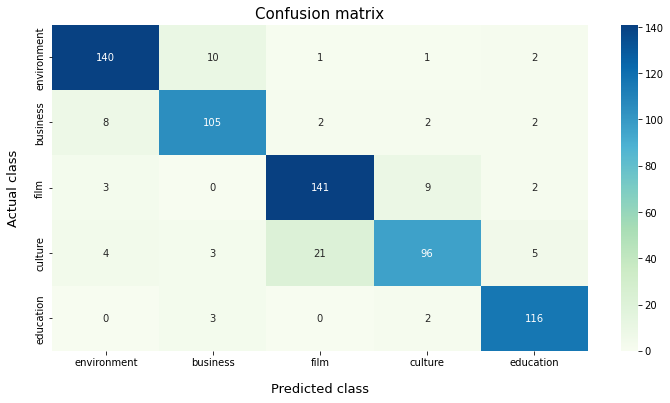

In [16]:
plt.figure(figsize=(12,6))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
            xticklabels=target_names,
            yticklabels=target_names,
            annot=True,
            fmt='d',
            cmap='GnBu')
ax.set_title("Confusion matrix", fontsize=15)
ax.set_xlabel('Predicted class', labelpad=15., fontsize=13);
ax.set_ylabel('Actual class', labelpad=15., fontsize=13);

In [17]:
summary = pd.DataFrame(data=
                      {'Model name': 'SVM',
                       'Training score': training_score,
                       'Test score': test_score},
                       index=[0])
summary

,Model name,Training score,Test score
0,SVM,0.998032,0.882006


In [18]:
with open("models/best_svm.pickle", 'wb') as file:
    pickle.dump(best_clf, file)
    
with open("models/summary_svm.pickle", 'wb') as file:
    pickle.dump(summary, file)